# 1. Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk

In [2]:
import re
import string

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import xgboost
from xgboost import XGBClassifier

In [8]:
# create empty list at beginning of every jupyter notebook
hyperparameter_table  = []

# 2. Load Datasets

In [9]:
# load dataset
news = pd.read_csv('../Data/news_classification_Feb06_24.csv', index_col=0, parse_dates=['date', 'election_day'])
news.head()

,title,text,subject,date,label,char_count_text,word_count_text,avg_word_length_text,char_count_title,word_count_title,avg_word_length_title,year,month,day,day_of_week,election_day,days_to_election
22216,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,2017-02-13,fake_news,1028,171,6.011696,89,14,6.357143,2017,2,13,0,2016-11-08,97
27917,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,2017-04-05,real_news,4820,771,6.251621,55,8,6.875000,2017,4,5,2,2016-11-08,148
25007,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,2017-09-27,real_news,1848,304,6.078947,64,10,6.400000,2017,9,27,2,2016-11-08,323
1377,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,2017-05-22,fake_news,1244,183,6.797814,89,12,7.416667,2017,5,22,0,2016-11-08,195
32476,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,2016-06-24,real_news,3137,529,5.930057,55,10,5.500000,2016,6,24,4,2016-11-08,-137


In [10]:
# check shape, rows and columns
news.shape

(37924, 17)

In [11]:
# check column names
news.columns

Index(['title', 'text', 'subject', 'date', 'label', 'char_count_text',
       'word_count_text', 'avg_word_length_text', 'char_count_title',
       'word_count_title', 'avg_word_length_title', 'year', 'month', 'day',
       'day_of_week', 'election_day', 'days_to_election'],
      dtype='object')

In [12]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37924 entries, 22216 to 28254
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  37924 non-null  object        
 1   text                   37924 non-null  object        
 2   subject                37924 non-null  object        
 3   date                   37924 non-null  datetime64[ns]
 4   label                  37924 non-null  object        
 5   char_count_text        37924 non-null  int64         
 6   word_count_text        37924 non-null  int64         
 7   avg_word_length_text   37924 non-null  float64       
 8   char_count_title       37924 non-null  int64         
 9   word_count_title       37924 non-null  int64         
 10  avg_word_length_title  37924 non-null  float64       
 11  year                   37924 non-null  int64         
 12  month                  37924 non-null  int64         
 13  da

In [13]:
news['month'] = news['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',\
                                  7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'})
news['day_of_week'] = news['day_of_week'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',\
                                               5:'Saturday', 6:'Sunday'})

In [14]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37924 entries, 22216 to 28254
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  37924 non-null  object        
 1   text                   37924 non-null  object        
 2   subject                37924 non-null  object        
 3   date                   37924 non-null  datetime64[ns]
 4   label                  37924 non-null  object        
 5   char_count_text        37924 non-null  int64         
 6   word_count_text        37924 non-null  int64         
 7   avg_word_length_text   37924 non-null  float64       
 8   char_count_title       37924 non-null  int64         
 9   word_count_title       37924 non-null  int64         
 10  avg_word_length_title  37924 non-null  float64       
 11  year                   37924 non-null  int64         
 12  month                  37924 non-null  object        
 13  da

# 3. Data Preprocessing and Modeling
**Two methods will be used for modeling:**

**The method 1 use features new created including character count, word count, average word length in title and text, year, month, day, day of week and days to election.**

**The method 2 use only the text column and vectorize with CountVectorizer() or TfidfVectorizer() with different parameters like ngram_range, max_df and min_df.**

## 3.1 Data Preparation

In [15]:
X = news[['char_count_text', 'word_count_text', 'avg_word_length_text', 'char_count_title',
       'word_count_title', 'avg_word_length_title', 'year', 'month', 'day', 'day_of_week', 'days_to_election']]
y = news.label
# get dummy of categorical variables
X = pd.get_dummies(X)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37924 entries, 22216 to 28254
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   char_count_text        37924 non-null  int64  
 1   word_count_text        37924 non-null  int64  
 2   avg_word_length_text   37924 non-null  float64
 3   char_count_title       37924 non-null  int64  
 4   word_count_title       37924 non-null  int64  
 5   avg_word_length_title  37924 non-null  float64
 6   year                   37924 non-null  int64  
 7   day                    37924 non-null  int64  
 8   days_to_election       37924 non-null  int64  
 9   month_Apr              37924 non-null  bool   
 10  month_Aug              37924 non-null  bool   
 11  month_Dec              37924 non-null  bool   
 12  month_Feb              37924 non-null  bool   
 13  month_Jan              37924 non-null  bool   
 14  month_Jul              37924 non-null  bool   
 15  mon

In [17]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [18]:
# check shapes
X_train.shape, X_test.shape

((34131, 28), (3793, 28))

## 3.2 Modeling

### 3.2.1 Method_1 Exp_1 Logistic Regression

In [19]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [20]:
# initiate the model
lr_classifier_1 = LogisticRegression(max_iter=1000)
# fit model
lr_classifier_1.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [21]:
# get train_score using cross validation in 5 folds
train_accuracy = np.mean(cross_val_score(lr_classifier_1, X_train, y_train, cv=5))

In [22]:
y_test_pred = lr_classifier_1.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [23]:
parameters = dict(Exp=1, Model_Name='Logistic Regression', n_Num=9,\
                  n_Cat=2, Cat_Encode='pd.get_dimmies()', Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5, Train_Accuracy=round(train_accuracy,2), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3))

hyperparameter_table[-1].update(parameters)

In [24]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision
Exp,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.89,0.897,0.93,0.888


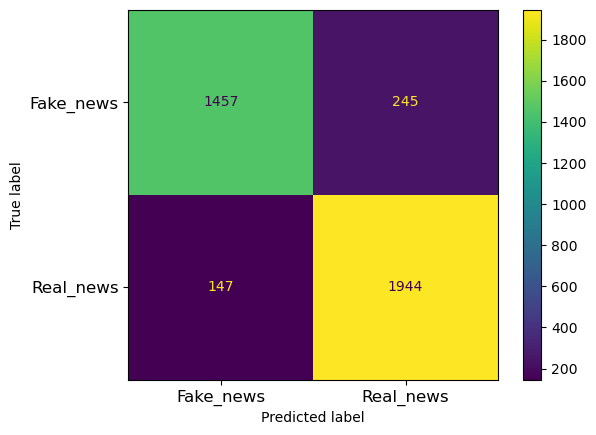

In [25]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier_1.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.2.2 Method_1 Exp_2 Random Forest Classifier

In [26]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [27]:
# initiate the model
rf_classifier_1 = RandomForestClassifier()
# fit model
rf_classifier_1.fit(X_train, y_train)

RandomForestClassifier()

In [28]:
# get train_score using cross validation in 5 folds
train_accuracy = np.mean(cross_val_score(rf_classifier_1, X_train, y_train, cv=5))

In [29]:
y_test_pred = rf_classifier_1.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [30]:
parameters = dict(Exp=2, Model_Name='RandomForest Classifier', n_Num=9,\
                  n_Cat=2, Cat_Encode='pd.get_dimmies()', Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3))

hyperparameter_table[-1].update(parameters)

In [31]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision
Exp,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916


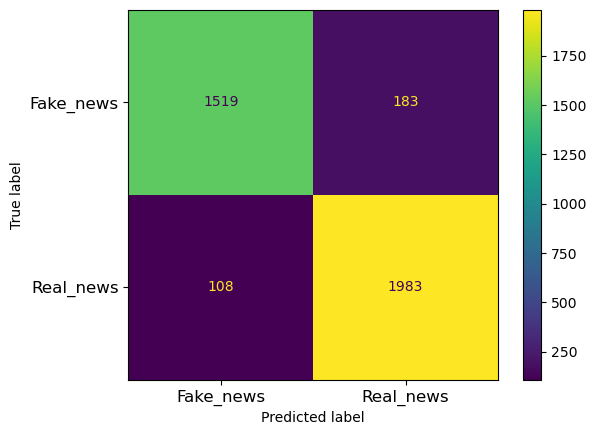

In [32]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = rf_classifier_1.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.2.3 Method_1 Exp_3 Gradient Boost Classifier

In [33]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [34]:
# initiate the model
gb_classifier_1 = GradientBoostingClassifier()
# fit model
gb_classifier_1.fit(X_train, y_train)

GradientBoostingClassifier()

In [35]:
# get train_score using cross validation in 5 folds
train_accuracy = np.mean(cross_val_score(gb_classifier_1, X_train, y_train, cv=5))

In [36]:
y_test_pred = gb_classifier_1.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [37]:
parameters = dict(Exp=3, Model_Name='GradientBoost Classifier', n_Num=9,\
                  n_Cat=2, Cat_Encode='pd.get_dimmies()', Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3))

hyperparameter_table[-1].update(parameters)

In [38]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision
Exp,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916
3,GradientBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.919,0.922,0.956,0.907


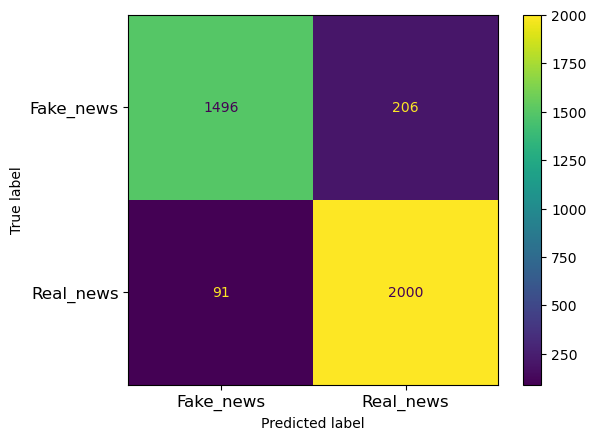

In [39]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = gb_classifier_1.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.2.4 Method_1 Exp_4 XGBoost Classifier

In [40]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [41]:
y_train_xgb = y_train.map({'fake_news':0, 'real_news':1})
y_test_xgb = y_test.map({'fake_news':0, 'real_news':1})

In [42]:
# initiate the model
xgb_classifier_1 = XGBClassifier()
# fit model
xgb_classifier_1.fit(X_train, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [43]:
# get train_score using cross validation in 5 folds
train_accuracy = np.mean(cross_val_score(xgb_classifier_1, X_train, y_train_xgb, cv=5))

In [44]:
y_test_pred = xgb_classifier_1.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test_xgb, y_test_pred)
test_recall = metrics.recall_score(y_test_xgb, y_test_pred)
test_precision = metrics.precision_score(y_test_xgb, y_test_pred)

In [45]:
parameters = dict(Exp=4, Model_Name='XGBoost Classifier', n_Num=9,\
                  n_Cat=2, Cat_Encode='pd.get_dimmies()', Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3))

hyperparameter_table[-1].update(parameters)

In [46]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision
Exp,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916
3,GradientBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.919,0.922,0.956,0.907
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918


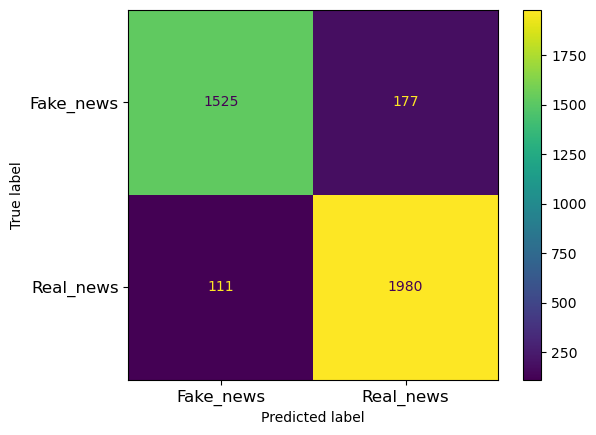

In [47]:
cm = metrics.confusion_matrix(y_test_xgb, y_test_pred, labels = xgb_classifier_1.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

## 3.2.5 Method_2 Exp_5 Logistic Regression with CountVectorizer

In [48]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [49]:
# assign X and y
X = news.text
y = news.label

In [50]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,1))
count_vectorizer_1 = CountVectorizer(**cv_kwargs)

In [51]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer_1.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_1.transform(X_test)

In [52]:
count_X_train.shape, count_X_test.shape

((34131, 115418), (3793, 115418))

In [53]:
# initiate the model
lr_classifier_2 = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier_2.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [54]:
train_accuracy = np.mean(cross_val_score(lr_classifier_2, count_X_train, y_train, cv=5))

In [55]:
y_test_pred = lr_classifier_2.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [56]:
parameters = dict(Exp=5, Model_Name='Logistic Regression', n_Num=0,\
                  n_Cat=1, Nlp_Encode='CountVectorizer()', n_Vector=count_X_train.shape[1], Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3))

hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [57]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Nlp_Encode,n_Vector,ngram_range
Exp,,,,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888,NaN,NaN,NaN
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916,NaN,NaN,NaN
3,GradientBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.919,0.922,0.956,0.907,NaN,NaN,NaN
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918,NaN,NaN,NaN
5,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.995,0.993,0.996,0.992,CountVectorizer(),115418.0,"(1, 1)"


In [58]:
coef = pd.Series(lr_classifier_2.coef_[0], index=count_vectorizer_1.get_feature_names_out())

In [59]:
coef.sort_values().tail()

wednesday     0.538133
saying        0.541868
said          0.622864
washington    0.777803
reuters       6.930527
dtype: float64

In [60]:
coef.sort_values().head()

via        -2.490440
read       -1.340916
com        -0.854978
featured   -0.812698
image      -0.805396
dtype: float64

## 3.2.6 Method_2 Exp_6 Logistic Regression with CountVectorizer

In [61]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [62]:
# remove news sources, especially locations and reuters
news['text'] = news['text'].apply(lambda x: x.split('-', 1)[1].strip()\
                                        if 'Reuters' in x and '-' in x and len(x.split('-')) > 1 else x)
# remove all reuters
news['text'] = news['text'].str.replace(r'Reuters|reuters|REUTERS', '', regex=True)

In [63]:
def remove_last_sentence(text):
        sentences = nltk.sent_tokenize(text)
        sentence = sentences[:-1] if sentences else ""
        return ''.join(sentence)

# remove news note, which is always last sentence.
news['text'] = news['text'].apply(remove_last_sentence)

In [64]:
# remove empty text rows
news = news[news['text']!='']

In [65]:
# assign X and y
X = news.text
y = news.label

In [66]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,1))
count_vectorizer_2 = CountVectorizer(**cv_kwargs)

In [67]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer_2.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_2.transform(X_test)

In [68]:
count_X_train.shape, count_X_test.shape

((33791, 109545), (3755, 109545))

In [69]:
# initiate the model
lr_classifier_3 = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier_3.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [70]:
train_accuracy = np.mean(cross_val_score(lr_classifier_3, count_X_train, y_train, cv=5))

In [71]:
y_test_pred = lr_classifier_3.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [72]:
parameters = dict(Exp=6, Model_Name='Logistic Regression', n_Num=0,\
                  n_Cat=1, Nlp_Encode='CountVectorizer()', n_Vector=count_X_train.shape[1], Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3), Del_HCoff='Yes')

hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [73]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Nlp_Encode,n_Vector,ngram_range,Del_HCoff
Exp,,,,,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888,NaN,NaN,NaN,NaN
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.919,0.922,0.956,0.907,NaN,NaN,NaN,NaN
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918,NaN,NaN,NaN,NaN
5,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.995,0.993,0.996,0.992,CountVectorizer(),115418.0,"(1, 1)",NaN
6,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.974,0.973,0.981,0.971,CountVectorizer(),109545.0,"(1, 1)",Yes


In [74]:
coef = pd.Series(lr_classifier_3.coef_[0], index=count_vectorizer_2.get_feature_names_out())

In [75]:
coef.sort_values().tail()

friday       1.664613
thursday     1.775872
wednesday    1.840292
est          2.120034
edt          2.263895
dtype: float64

In [76]:
coef.sort_values().head()

gop   -1.832850
sen   -1.772279
rep   -1.676818
com   -1.640694
mr    -1.405947
dtype: float64

## 3.2.7 Method_2 Exp_7 Logistic Regression with CountVectorizer

In [77]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [78]:
# assign X and y
X = news.text
y = news.label

In [79]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,1), max_df=0.8)
count_vectorizer_3 = CountVectorizer(**cv_kwargs)

In [80]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer_3.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_3.transform(X_test)

In [81]:
count_X_train.shape, count_X_test.shape

((33791, 109537), (3755, 109537))

In [82]:
# initiate the model
lr_classifier_4 = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier_4.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [83]:
train_accuracy = np.mean(cross_val_score(lr_classifier_4, count_X_train, y_train, cv=5))

In [84]:
y_test_pred = lr_classifier_4.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [85]:
parameters = dict(Exp=7, Model_Name='Logistic Regression', n_Num=0,\
                  n_Cat=1, Nlp_Encode='CountVectorizer()',  n_Vector=count_X_train.shape[1], Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5, Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3), Del_HCoff='Yes')

hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [86]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Nlp_Encode,n_Vector,ngram_range,Del_HCoff,max_df
Exp,,,,,,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.919,0.922,0.956,0.907,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.995,0.993,0.996,0.992,CountVectorizer(),115418.0,"(1, 1)",NaN,NaN
6,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.974,0.973,0.981,0.971,CountVectorizer(),109545.0,"(1, 1)",Yes,NaN
7,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.972,0.970,0.976,0.970,CountVectorizer(),109537.0,"(1, 1)",Yes,0.8


In [87]:
coef = pd.Series(lr_classifier_4.coef_[0], index=count_vectorizer_3.get_feature_names_out())

In [88]:
coef.sort_values().tail()

friday       2.123949
thursday     2.211792
wednesday    2.257860
est          2.282386
edt          2.298910
dtype: float64

In [89]:
coef.sort_values().head()

gop   -1.930211
sen   -1.900220
rep   -1.738756
com   -1.668712
mr    -1.481654
dtype: float64

## 3.2.8 Method_2 Exp_8 Logistic Regression with CountVectorizer

In [90]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [91]:
# assign X and y
X = news.text
y = news.label

In [92]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,1), min_df=0.1)
count_vectorizer_4 = CountVectorizer(**cv_kwargs)

In [93]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer_4.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_4.transform(X_test)

In [94]:
count_X_train.shape, count_X_test.shape

((33791, 300), (3755, 300))

In [95]:
# initiate the model
lr_classifier_5 = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier_5.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [96]:
train_accuracy = np.mean(cross_val_score(lr_classifier_5, count_X_train, y_train, cv=5))

In [97]:
y_test_pred = lr_classifier_5.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [98]:
parameters = dict(Exp=8, Model_Name='Logistic Regression', n_Num=0,\
                  n_Cat=1, Nlp_Encode='CountVectorizer()',  n_Vector=count_X_train.shape[1], Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3), Del_HCoff='Yes')

hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [99]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Nlp_Encode,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888,NaN,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916,NaN,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.919,0.922,0.956,0.907,NaN,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918,NaN,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.995,0.993,0.996,0.992,CountVectorizer(),115418.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.974,0.973,0.981,0.971,CountVectorizer(),109545.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.972,0.970,0.976,0.970,CountVectorizer(),109537.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.952,0.953,0.966,0.950,CountVectorizer(),300.0,"(1, 1)",Yes,NaN,0.1


In [100]:
coef = pd.Series(lr_classifier_5.coef_[0], index=count_vectorizer_4.get_feature_names_out())

In [101]:
coef.sort_values().tail()

reporters    0.671262
thursday     0.671848
said         0.689407
barack       0.855180
minister     0.866805
dtype: float64

In [102]:
coef.sort_values().head()

didn      -1.053302
us        -0.848025
hillary   -0.845723
just      -0.731150
fact      -0.663002
dtype: float64

## 3.2.9 Method_2 Exp_9 Logistic Regression with CountVectorizer

In [103]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [104]:
# assign X and y
X = news.text
y = news.label

In [105]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,1), max_df=0.8, min_df=0.1)
count_vectorizer_5 = CountVectorizer(**cv_kwargs)

In [106]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer_5.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_5.transform(X_test)

In [107]:
count_X_train.shape, count_X_test.shape

((33791, 292), (3755, 292))

In [108]:
# initiate the model
lr_classifier_6 = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier_6.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [109]:
train_accuracy = np.mean(cross_val_score(lr_classifier_6, count_X_train, y_train, cv=5))

In [110]:
y_test_pred = lr_classifier_6.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [111]:
parameters = dict(Exp=9, Model_Name='Logistic Regression', n_Num=0,\
                  n_Cat=1, Nlp_Encode='CountVectorizer()',  n_Vector=count_X_train.shape[1], Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3), Del_HCoff='Yes')

hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [112]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Nlp_Encode,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888,NaN,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916,NaN,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.919,0.922,0.956,0.907,NaN,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918,NaN,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.995,0.993,0.996,0.992,CountVectorizer(),115418.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.974,0.973,0.981,0.971,CountVectorizer(),109545.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.972,0.970,0.976,0.970,CountVectorizer(),109537.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.952,0.953,0.966,0.950,CountVectorizer(),300.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.947,0.944,0.962,0.938,CountVectorizer(),292.0,"(1, 1)",Yes,0.8,0.1


In [113]:
coef = pd.Series(lr_classifier_6.coef_[0], index=count_vectorizer_5.get_feature_names_out())

In [114]:
coef.sort_values().tail()

tuesday      0.721846
thursday     0.777521
wednesday    0.787688
barack       0.902468
minister     0.913954
dtype: float64

In [115]:
coef.sort_values().head()

didn      -1.093927
hillary   -0.889147
us        -0.832861
just      -0.738331
fact      -0.733946
dtype: float64

## 3.2.10 Method_2 Exp_10 Logistic Regression with CountVectorizer

In [116]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [117]:
# assign X and y
X = news.text
y = news.label

In [118]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(2,2), max_df=0.8, min_df=0.1)
count_vectorizer_6 = CountVectorizer(**cv_kwargs)

In [119]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer_6.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_6.transform(X_test)

In [120]:
count_X_train.shape, count_X_test.shape

((33791, 91), (3755, 91))

In [121]:
# initiate the model
lr_classifier_7 = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier_7.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [122]:
train_accuracy = np.mean(cross_val_score(lr_classifier_7, count_X_train, y_train, cv=5))

In [123]:
y_test_pred = lr_classifier_7.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [124]:
parameters = dict(Exp=10, Model_Name='Logistic Regression', n_Num=0,\
                  n_Cat=1, Nlp_Encode='CountVectorizer()',  n_Vector=count_X_train.shape[1], Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3), Del_HCoff='Yes')


hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [125]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Nlp_Encode,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888,NaN,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916,NaN,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.919,0.922,0.956,0.907,NaN,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918,NaN,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.995,0.993,0.996,0.992,CountVectorizer(),115418.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.974,0.973,0.981,0.971,CountVectorizer(),109545.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.972,0.970,0.976,0.970,CountVectorizer(),109537.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.952,0.953,0.966,0.950,CountVectorizer(),300.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.947,0.944,0.962,0.938,CountVectorizer(),292.0,"(1, 1)",Yes,0.8,0.1


In [126]:
coef = pd.Series(lr_classifier_7.coef_[0], index=count_vectorizer_6.get_feature_names_out())

In [127]:
coef.sort_values().tail()

on thursday         1.751809
on tuesday          1.792064
on wednesday        1.869980
president donald    2.220432
said on             2.475959
dtype: float64

In [128]:
coef.sort_values().head()

this is        -1.040846
that they      -0.775880
donald trump   -0.716154
that he        -0.599134
that the       -0.538694
dtype: float64

## 3.2.11 Method_2 Exp_11 Logistic Regression with CountVectorizer

In [129]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [130]:
# assign X and y
X = news.text
y = news.label

In [131]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,2), max_df=0.8, min_df=0.1)
count_vectorizer_7 = CountVectorizer(**cv_kwargs)

In [132]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer_7.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_7.transform(X_test)

In [133]:
count_X_train.shape, count_X_test.shape

((33791, 383), (3755, 383))

In [134]:
# initiate the model
lr_classifier_8 = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier_8.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [135]:
train_accuracy = np.mean(cross_val_score(lr_classifier_8, count_X_train, y_train, cv=5))

In [136]:
y_test_pred = lr_classifier_8.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [137]:
parameters = dict(Exp=11, Model_Name='Logistic Regression', n_Num=0,\
                  n_Cat=1, Nlp_Encode='CountVectorizer()',  n_Vector=count_X_train.shape[1], Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3), Del_HCoff='Yes')


hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [138]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Nlp_Encode,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888,NaN,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916,NaN,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.919,0.922,0.956,0.907,NaN,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918,NaN,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.995,0.993,0.996,0.992,CountVectorizer(),115418.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.974,0.973,0.981,0.971,CountVectorizer(),109545.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.972,0.970,0.976,0.970,CountVectorizer(),109537.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.952,0.953,0.966,0.950,CountVectorizer(),300.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.947,0.944,0.962,0.938,CountVectorizer(),292.0,"(1, 1)",Yes,0.8,0.1


In [139]:
coef = pd.Series(lr_classifier_8.coef_[0], index=count_vectorizer_7.get_feature_names_out())

In [140]:
coef.sort_values().tail()

on friday       2.258664
on thursday     2.590488
on tuesday      2.659931
on monday       2.674139
on wednesday    2.785861
dtype: float64

In [141]:
coef.sort_values().head()

wednesday   -1.149802
monday      -1.076312
york        -1.050099
barack      -1.005903
hillary     -0.980758
dtype: float64

## 3.2.12 Method_2 Exp_12 Logistic Regression with CountVectorizer

In [142]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [143]:
# assign X and y
X = news.text
y = news.label

In [144]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,2), max_df=0.8, min_df=0.2)
count_vectorizer_8 = CountVectorizer(**cv_kwargs)

In [145]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer_8.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_8.transform(X_test)

In [146]:
count_X_train.shape, count_X_test.shape

((33791, 143), (3755, 143))

In [147]:
# initiate the model
lr_classifier_9 = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier_9.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [148]:
train_accuracy = np.mean(cross_val_score(lr_classifier_9, count_X_train, y_train, cv=5))

In [149]:
y_test_pred = lr_classifier_9.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [150]:
parameters = dict(Exp=12, Model_Name='Logistic Regression', n_Num=0,\
                  n_Cat=1, Nlp_Encode='CountVectorizer()', n_Vector=count_X_train.shape[1], Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3), Del_HCoff='Yes')


hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [151]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Nlp_Encode,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888,NaN,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916,NaN,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.919,0.922,0.956,0.907,NaN,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918,NaN,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.995,0.993,0.996,0.992,CountVectorizer(),115418.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.974,0.973,0.981,0.971,CountVectorizer(),109545.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.972,0.970,0.976,0.970,CountVectorizer(),109537.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.952,0.953,0.966,0.950,CountVectorizer(),300.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.947,0.944,0.962,0.938,CountVectorizer(),292.0,"(1, 1)",Yes,0.8,0.1


In [152]:
coef = pd.Series(lr_classifier_9.coef_[0], index=count_vectorizer_8.get_feature_names_out())

In [153]:
coef.sort_values().tail()

week          0.338274
republican    0.378794
the united    0.517124
said          0.690144
said on       2.152334
dtype: float64

In [154]:
coef.sort_values().head()

just        -0.716227
according   -0.617649
this        -0.526620
that the    -0.525299
even        -0.508734
dtype: float64

## 3.2.13 Method_2 Exp_13 Logistic Regression with TfidfVectorizer

In [155]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [156]:
# assign X and y
X = news.text
y = news.label

In [157]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize a TfidfVectorizer object: tfidf_vectorizer
cv_kwargs = dict(ngram_range=(1,2), max_df=0.8, min_df=0.1)
tfidf_vectorizer_1 = TfidfVectorizer(**cv_kwargs)

In [158]:
# Transform the training data using only the 'text' column values: tfidf_train 
tfidf_X_train = tfidf_vectorizer_1.fit_transform(X_train)

# Transform the test data using only the 'text' column values: tfidf_test 
tfidf_X_test = tfidf_vectorizer_1.transform(X_test)

In [159]:
tfidf_X_train.shape, tfidf_X_test.shape

((26282, 385), (11264, 385))

In [160]:
# initiate the model
lr_classifier_10 = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier_10.fit(tfidf_X_train, y_train)

LogisticRegression(max_iter=1000)

In [161]:
train_accuracy = np.mean(cross_val_score(lr_classifier_10, tfidf_X_train, y_train, cv=5))

In [162]:
y_test_pred = lr_classifier_10.predict(tfidf_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [163]:
parameters = dict(Exp=13, Model_Name='Logistic Regression', n_Num=0,\
                  n_Cat=1, Nlp_Encode='TfidfVectorizer()', n_Vector=tfidf_X_train.shape[1], Test_P=0.1, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Val_Accuracy=round(test_accuracy,3),\
                  Val_Recall=round(test_recall,3), Val_Precision=round(test_precision,3), Del_HCoff='Yes')


hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [164]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Nlp_Encode,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.890,0.897,0.930,0.888,NaN,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.923,0.948,0.916,NaN,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.919,0.922,0.956,0.907,NaN,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918,NaN,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.995,0.993,0.996,0.992,CountVectorizer(),115418.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.974,0.973,0.981,0.971,CountVectorizer(),109545.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.972,0.970,0.976,0.970,CountVectorizer(),109537.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.952,0.953,0.966,0.950,CountVectorizer(),300.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.947,0.944,0.962,0.938,CountVectorizer(),292.0,"(1, 1)",Yes,0.8,0.1


In [165]:
coef = pd.Series(lr_classifier_10.coef_[0], index=tfidf_vectorizer_1.get_feature_names_out())

In [166]:
coef.sort_values().tail()

on thursday      6.938134
said on          7.196461
on tuesday       7.264420
on wednesday     7.334766
said            13.490131
dtype: float64

In [167]:
coef.sort_values().head()

this       -6.824388
just       -6.024905
us         -4.950278
didn       -4.752580
that the   -4.415943
dtype: float64

## 3.3 Performance Test
### 3.3.1 Data Preparation

In [168]:
pd.DataFrame(hyperparameter_table).set_index('Exp').sort_values('Val_Accuracy', ascending=False)

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Nlp_Encode,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
5,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.995,0.993,0.996,0.992,CountVectorizer(),115418.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.974,0.973,0.981,0.971,CountVectorizer(),109545.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.972,0.970,0.976,0.970,CountVectorizer(),109537.0,"(1, 1)",Yes,0.8,NaN
11,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.960,0.958,0.967,0.957,CountVectorizer(),383.0,"(1, 2)",Yes,0.8,0.1
13,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.960,0.958,0.968,0.956,TfidfVectorizer(),385.0,"(1, 2)",Yes,0.8,0.1
8,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.952,0.953,0.966,0.950,CountVectorizer(),300.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.947,0.944,0.962,0.938,CountVectorizer(),292.0,"(1, 1)",Yes,0.8,0.1
12,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.932,0.932,0.954,0.925,CountVectorizer(),143.0,"(1, 2)",Yes,0.8,0.2
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918,NaN,NaN,NaN,NaN,NaN,NaN


**Get real news from reuters, cnn and npr.**     
**Get fake news from breitbart and thegatewaypundit.**    
**Totally 25 news**

In [169]:
test = pd.read_csv('../Data/test_set_Feb29_2024.csv', parse_dates=['date'])
test

,title,text,label,source,url,date
0,Exclusive: Former Biden Aide Paid Fani Willis’...,The money flow is significant because sources ...,fake_news,breitbart,https://www.breitbart.com/politics/2024/02/29/...,2024-02-29
1,Judges in Trump-related cases face unprecedent...,U.S.District Judge Royce Lamberth has been thr...,real_news,reuters,https://www.reuters.com/investigates/special-r...,2024-02-29
2,Meet the Experienced Democrat Operative the Bi...,The Biden regime’s collusion with corrupt Fult...,fake_news,thegatewaypundit,https://www.thegatewaypundit.com/2024/02/meet-...,2024-02-26
3,Biden pressures Trump to unblock migrant plan ...,"U.S. President Joe Biden and Donald Trump, his...",real_news,reuters,https://www.reuters.com/world/us/biden-trump-m...,2024-02-29
4,Biden and Trump’s dueling border visits will e...,Two presidents will visit the southern US bord...,real_news,cnn,https://www.cnn.com/2024/02/29/politics/border...,2024-02-29
5,WOW! Biden’s Stiff Gait as He Shuffles Along D...,"Joe Biden arrived in Brownsville, Texas on Thu...",fake_news,thegatewaypundit,https://www.thegatewaypundit.com/2024/02/wow-b...,2024-02-29
6,Biden has eight months to fix his Michigan pro...,If the Democratic voters of Michigan – and a h...,real_news,cnn,https://www.cnn.com/2024/02/28/politics/biden-...,2024-02-28
7,Some Democrats turn toward Trump in Texas bord...,"Asalia Casares, 52, is a lifelong Democrat who...",real_news,reuters,https://www.reuters.com/world/us/some-democrat...,2024-02-29
8,WAYNE ROOT: “Do You Believe in Miracles?” Some...,“Do you believe in miracles?” Remember those w...,fake_news,thegatewaypundit,https://www.thegatewaypundit.com/2024/02/wayne...,2024-02-29
9,Trump says he cannot get fair trial this year ...,Donald Trump's lawyers told a U.S. judge on Th...,real_news,reuters,https://www.reuters.com/world/us/trump-asks-de...,2024-02-29


In [170]:
test['char_count_text'] = test['text'].str.len()
test['word_count_text'] = test['text'].str.split().str.len()
test['avg_word_length_text'] = test['char_count_text']/test['word_count_text']

test['char_count_title'] = test['title'].str.len()
test['word_count_title'] = test['title'].str.split().str.len()
test['avg_word_length_title'] = test['char_count_title']/test['word_count_title']

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.weekday

In [171]:
test['election_day'] = pd.to_datetime("2024-11-05")
test['days_to_election'] = (test['date'] - test['election_day']).dt.days

In [172]:
test['month'] = test['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',\
                                  7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'})
test['day_of_week'] = test['day_of_week'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',\
                                               5:'Saturday', 6:'Sunday'})

### 3.3.2 Method_1 Test_1 

In [173]:
# assign X and y
X_test = test[['char_count_text', 'word_count_text', 'avg_word_length_text', 'char_count_title',
       'word_count_title', 'avg_word_length_title', 'year', 'month', 'day', 'day_of_week', 'days_to_election']]
X_test = pd.get_dummies(X_test)
y_test = test.label

In [174]:
for i in ['month_Jan', 'month_Apr', 'month_May', 'month_Jun', 'month_Jul', 'month_Aug', 'month_Sept',\
'month_Oct', 'month_Nov', 'month_Dec', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Tuesday']:
    X_test[i] = False
X_test = X_test[['char_count_text', 'word_count_text', 'avg_word_length_text', 'char_count_title', 'word_count_title',\
                 'avg_word_length_title', 'year', 'day', 'days_to_election', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb',\
                 'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct', 'month_Sept',\
                 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',\
                 'day_of_week_Tuesday', 'day_of_week_Wednesday']]
X_test.head()

,char_count_text,word_count_text,avg_word_length_text,char_count_title,word_count_title,avg_word_length_title,year,day,days_to_election,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sept,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,2896,456,6.350877,85,14,6.071429,2024,29,-250,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,5800,918,6.318083,64,9,7.111111,2024,29,-250,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,2885,443,6.512415,177,26,6.807692,2024,26,-253,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,4064,656,6.195122,74,11,6.727273,2024,29,-250,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,10675,1723,6.195589,82,12,6.833333,2024,29,-250,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


In [175]:
y_test_pred = lr_classifier_1.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [176]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.6
The test set precision score is 0.8
The test set recall score is 0.308


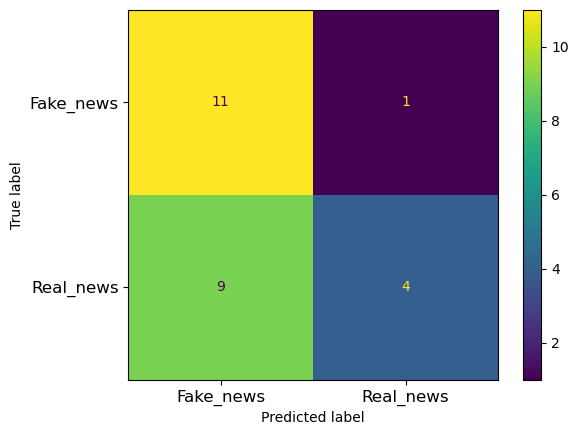

In [177]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier_1.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [178]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[0].update(result)

### 3.3.3 Method_1 Test_2

In [179]:
y_test_pred = rf_classifier_1.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [180]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.68
The test set precision score is 0.857
The test set recall score is 0.462


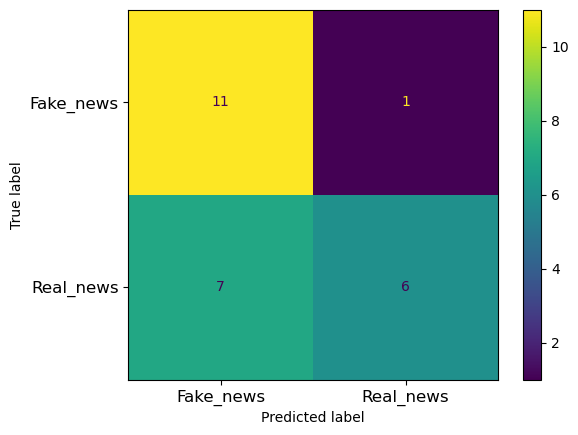

In [181]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = rf_classifier_1.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [182]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[1].update(result)

### 3.3.4 Method_1 Test_3

In [183]:
y_test_pred = gb_classifier_1.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [184]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.68
The test set precision score is 0.857
The test set recall score is 0.462


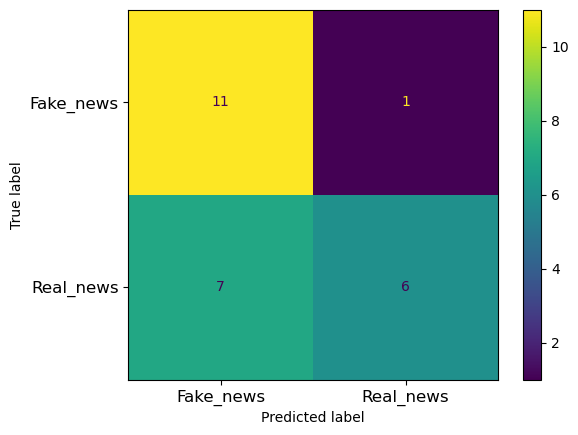

In [185]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = gb_classifier_1.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [186]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[2].update(result)

### 3.3.5 Method_1 Test_4

In [187]:
y_test_xgb = y_test.map({'fake_news':0, 'real_news':1})

y_test_pred = xgb_classifier_1.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test_xgb, y_test_pred)
test_recall = metrics.recall_score(y_test_xgb, y_test_pred)
test_precision = metrics.precision_score(y_test_xgb, y_test_pred)

In [188]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.76
The test set precision score is 0.889
The test set recall score is 0.615


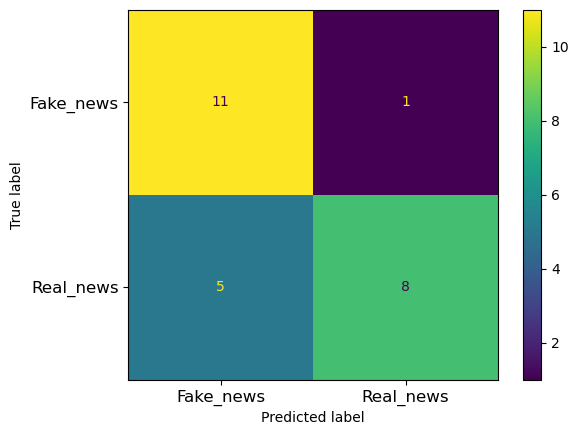

In [189]:
cm = metrics.confusion_matrix(y_test_xgb, y_test_pred, labels = xgb_classifier_1.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [190]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[3].update(result)

### 3.3.6 Method_2 Test_5

In [191]:
# assign X and y
X_test = test.text
y_test = test.label

In [192]:
# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_1.transform(X_test)

In [193]:
y_test_pred = lr_classifier_2.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [194]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.88
The test set precision score is 1.0
The test set recall score is 0.769


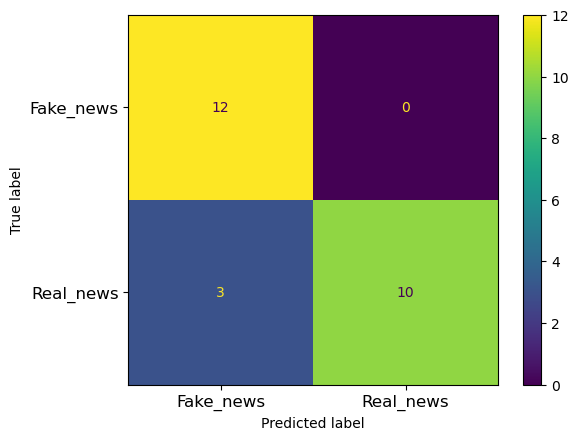

In [195]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier_2.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [196]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[4].update(result)

### 3.3.7 Method_2 Test_6

In [197]:
# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_2.transform(X_test)

In [198]:
y_test_pred = lr_classifier_3.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [199]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.88
The test set precision score is 1.0
The test set recall score is 0.769


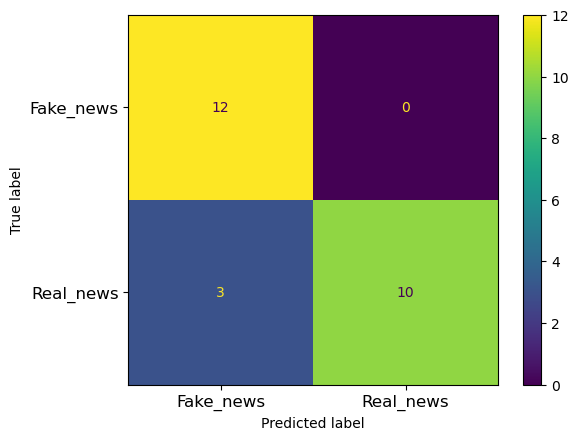

In [200]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier_3.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [201]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[5].update(result)

### 3.3.8 Method_2 Test_7

In [202]:
# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_3.transform(X_test)

In [203]:
y_test_pred = lr_classifier_4.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [204]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.92
The test set precision score is 1.0
The test set recall score is 0.846


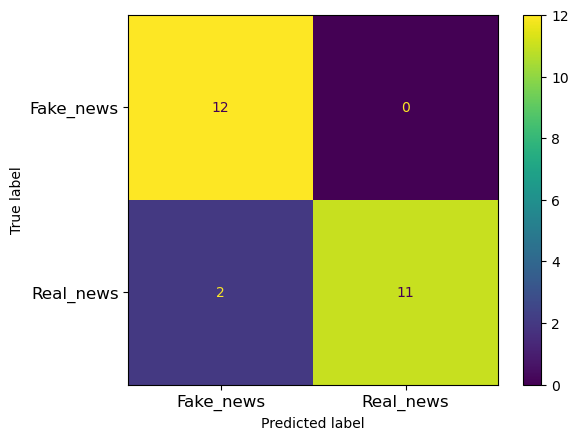

In [205]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier_4.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [206]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[6].update(result)

### 3.3.9 Method_2 Test_8

In [207]:
# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_4.transform(X_test)

In [208]:
y_test_pred = lr_classifier_5.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [209]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.88
The test set precision score is 0.857
The test set recall score is 0.923


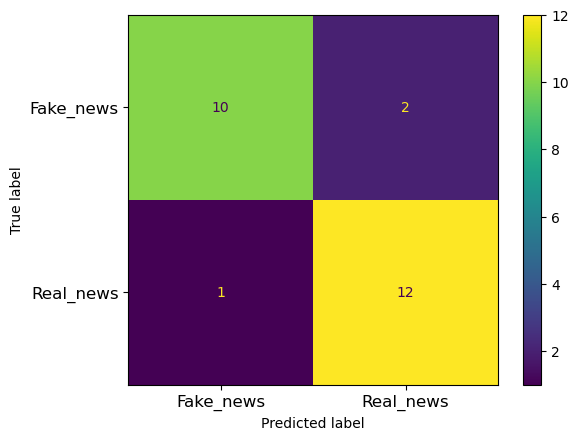

In [210]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier_5.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [211]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[7].update(result)

### 3.3.10 Method_2 Test_9

In [212]:
# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_5.transform(X_test)

In [213]:
y_test_pred = lr_classifier_6.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [214]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.92
The test set precision score is 0.867
The test set recall score is 1.0


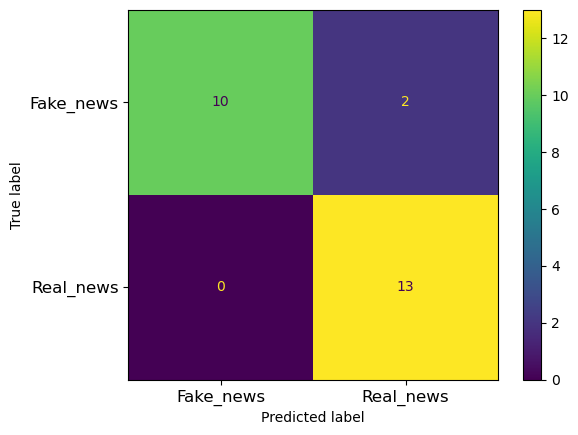

In [215]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier_6.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [216]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[8].update(result)

### 3.3.11 Method_2 Test_10

In [217]:
# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_6.transform(X_test)

In [218]:
y_test_pred = lr_classifier_7.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [219]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.6
The test set precision score is 0.6
The test set recall score is 0.692


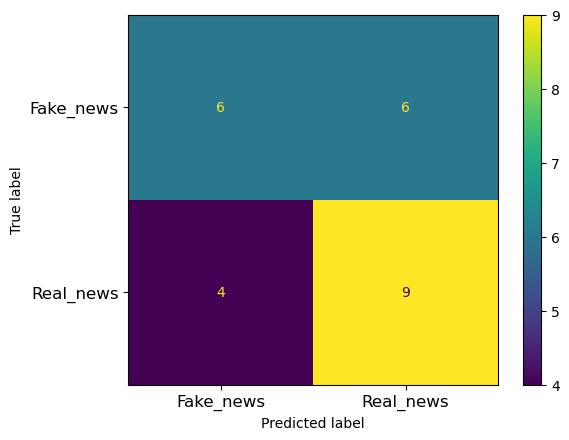

In [220]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier_7.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [221]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[9].update(result)

### 3.3.12 Method_2 Test_11

In [222]:
# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_7.transform(X_test)

In [223]:
y_test_pred = lr_classifier_8.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [224]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.84
The test set precision score is 0.846
The test set recall score is 0.846


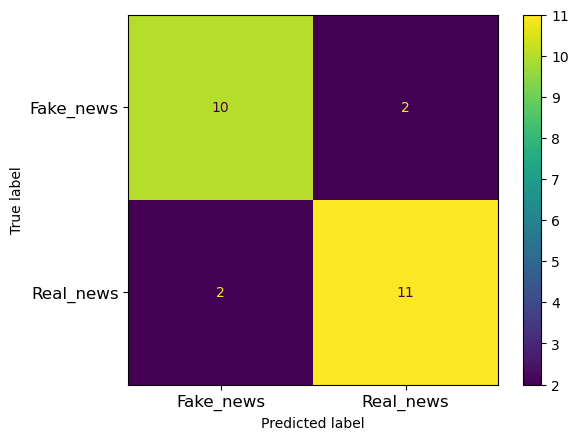

In [225]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier_8.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [226]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[10].update(result)

### 3.3.13 Method_2 Test_12

In [227]:
# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer_8.transform(X_test)

In [228]:
y_test_pred = lr_classifier_9.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [229]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.8
The test set precision score is 0.833
The test set recall score is 0.769


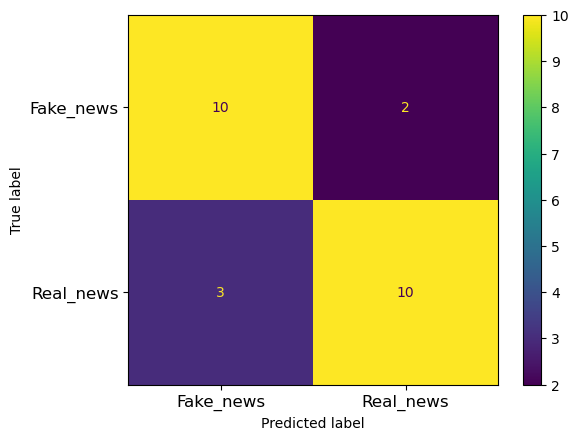

In [230]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier_9.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [231]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[11].update(result)

### 3.3.14 Method_2 Test_13

In [232]:
# Transform the test data using only the 'text' column values: count_test 
tfidf_X_test = tfidf_vectorizer_1.transform(X_test)

In [233]:
y_test_pred = lr_classifier_10.predict(tfidf_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [234]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.84
The test set precision score is 0.846
The test set recall score is 0.846


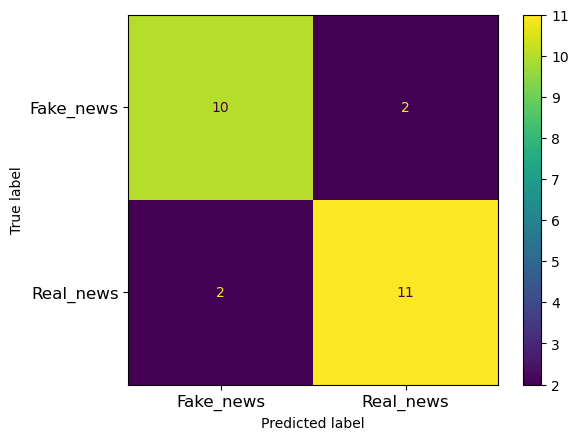

In [235]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier_10.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

In [236]:
result = dict(Test_Accuracy=round(test_accuracy,3), Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[12].update(result)

In [239]:
pd.DataFrame(hyperparameter_table).set_index('Exp').sort_values('Test_Accuracy', ascending=False)

,Model_Name,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Val_Accuracy,Val_Recall,Val_Precision,Test_Accuracy,Test_Recall,Test_Precision,Nlp_Encode,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,,,,
7,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.972,0.970,0.976,0.970,0.92,0.846,1.000,CountVectorizer(),109537.0,"(1, 1)",Yes,0.8,NaN
9,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.947,0.944,0.962,0.938,0.92,1.000,0.867,CountVectorizer(),292.0,"(1, 1)",Yes,0.8,0.1
5,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.995,0.993,0.996,0.992,0.88,0.769,1.000,CountVectorizer(),115418.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.974,0.973,0.981,0.971,0.88,0.769,1.000,CountVectorizer(),109545.0,"(1, 1)",Yes,NaN,NaN
8,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.952,0.953,0.966,0.950,0.88,0.923,0.857,CountVectorizer(),300.0,"(1, 1)",Yes,NaN,0.1
11,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.960,0.958,0.967,0.957,0.84,0.846,0.846,CountVectorizer(),383.0,"(1, 2)",Yes,0.8,0.1
13,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.960,0.958,0.968,0.956,0.84,0.846,0.846,TfidfVectorizer(),385.0,"(1, 2)",Yes,0.8,0.1
12,Logistic Regression,0,1,NaN,0.1,No,Yes,5,0.932,0.932,0.954,0.925,0.80,0.769,0.833,CountVectorizer(),143.0,"(1, 2)",Yes,0.8,0.2
4,XGBoost Classifier,9,2,pd.get_dimmies(),0.1,No,Yes,5,0.918,0.924,0.947,0.918,0.76,0.615,0.889,NaN,NaN,NaN,NaN,NaN,NaN


# 4. Output

In [240]:
pd.DataFrame(hyperparameter_table).set_index('Exp').to_csv('../Data/hyperparameter_table_Feb29_2024.csv')

In [241]:
news.to_csv('../Data/news_classification_Feb29_24.csv')

# 5. Conclusion

**Based on the test performance result:** 

**1. Method_2 Test_7 with CountVectorizer(ngram=1, max_df=0.8), test accuracy is 0.92, precision score is 1.0, which means all fake news are correctly labelled, only two real news are falsely labelled as fake news, result in recall score 0.846.**      

**2. Method_2 Test_9 with CountVectorizer(ngram=1, max_df=0.8, min_df=0.1), test accuracy is 0.92, but have recall score 1.0, which means all real news are correctly labelled, two fake news are falsely labelled as real news, which result in precision score 0.867.**  

**3. Method_2 Test_5 with CountVectorizer(ngram=1) before delete high coefficient terms, test accuracy is 0.88, but precision score 1, however, the recall score is 0.769.**

**4. Method_2 Test_6 with CountVectorizer(ngram=1) after delete high coefficient terms, test accuracy is 0.88, but precision score 1, however, the recall score is 0.769, very similar to Test_5**

**5. Method_2 Test_8 with CountVectorizer(ngram=1, min_df=0.1), test accuracy is 0.88, but precision score 0.857, the recall score is 0.923.**

**6. Method_2 Test_11 with CountVectorizer(ngram=1-2, max_df=0.8, min_df=0.1) and Method_2 Test_13 with TfidfVectorizer(ngram=1-2, max_df=0.8, min_df=0.1) get same results, test accuracy is 0.84, precision score 0.846, recall score 0.846.**

**7. The two tests with the worst performance using Method_2 are Test_12 with CountVectorizer(ngram=1-2, max_df=0.8, min_df=0.2) and Test_10 with CountVectorizer(ngram=2, max_df=0.8, min_df=0.1) test accuracy is 0.80 and 0.60 separately, precision score 0.833 and 0.600 separately, recall score 0.769 and 0.692 separately. The latter one even worse than tests using Method_1.**

**8. The best model using Method_1 with features like character count, word count in text and title etc is Test_4 using XGBoost Classifier, test accuracy is 0.76, precision score is 0.889, recall score 0.615.** 

**9. Method_1 Test_2 and Test_3 using RandomForest Classifier and GradientBoost Classifier get same results, test accuracy is 0.68, precision score is 0.857,  recall score 0.462, which means their strength in predicting real news are weak, more than 50% were labeled not correctly.**

**10. Method_1 Test_2 and Test_3 using RandomForest Classifier and GradientBoost Classifier get same results, test accuracy is 0.68, precision score is 0.857,  recall score 0.462, which means their strength in predicting real news are weak, more than 50% were labeled not correctly.**

**10. Method_1 Test_1 using Logistic Regression get worst results, test accuracy is 0.60, precision score is 0.8,  recall score 0.308. This is the worst in all tests**

**Concluded that the Method_2 performs better than Method_1, which makes sense. Since the properties like character count, word count, date etc can NOT be generalized well, but the text vector can be generalized well.**

# 6. Future Work

**Try other vectorize methods using packages like spacy, gensim etc. Detail info will be discussed in report and separate notebook.**